In [1]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#Deep learning imports
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import metrics
from tensorflow.keras.layers import Dense, Dropout

# Building a neural network

In [2]:
#Generating random data
input_shape = (784)
X_test = np.random.random((1000, 784))
y_test = np.random.randint(2, size=(1000, 1))
X_train = np.random.random((600, 784))
y_train = np.random.randint(2, size=(600, 1))

In [3]:
def build_model():
  #Instantiate the model
  model = Sequential()
  #Hidden layer
  model.add(Dense(128, input_dim =input_shape, activation='relu'))
  #output layer
  model.add(Dense(1, activation = 'sigmoid')) # using the linear activation function

  # Compile
  model.compile(loss = 'bce', optimizer = 'adam',
                metrics=['accuracy',
                         tf.keras.metrics.Recall(name='recall'),
                         tf.keras.metrics.Precision(name='precision'),
                        ])
  return model

In [4]:
bin_model = build_model()

# Get model summary
bin_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 100609 (393.00 KB)
Trainable params: 100609 (393.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [5]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5)

In [6]:
history = bin_model.fit(X_train, y_train,
                        validation_split = .2,
                        epochs=50,
                        verbose=0, callbacks = [early_stop])

In [7]:
# Custom function for plotting each metric
def plot_history(history, figsize=(6,12), marker='o'):

    # Get list of metrics from history
    metrics = [c for c in history.history if not c.startswith('val_')]

    ## Separate row for each metric
    fig, axes = plt.subplots(nrows=len(metrics),figsize=figsize)

    # For each metric
    for i, metric_name in enumerate(metrics):

        # Get the axis for the current metric
        ax = axes[i]

        # Get metric from history.history
        metric_values = history.history[metric_name]
        # Get epochs from history
        epochs = history.epoch

        # Plot the training metric
        ax.plot(epochs, metric_values, label=metric_name, marker=marker)

        ## Check if val_{metric} exists. if so, plot:
        val_metric_name = f"val_{metric_name}"
        if val_metric_name in history.history:
            # Get validation values and plot
            metric_values = history.history[val_metric_name]
            ax.plot(epochs,metric_values,label=val_metric_name, marker=marker)

        # Final subplot adjustments
        ax.legend()
        ax.set_title(metric_name)
    fig.tight_layout()

    return fig, axes

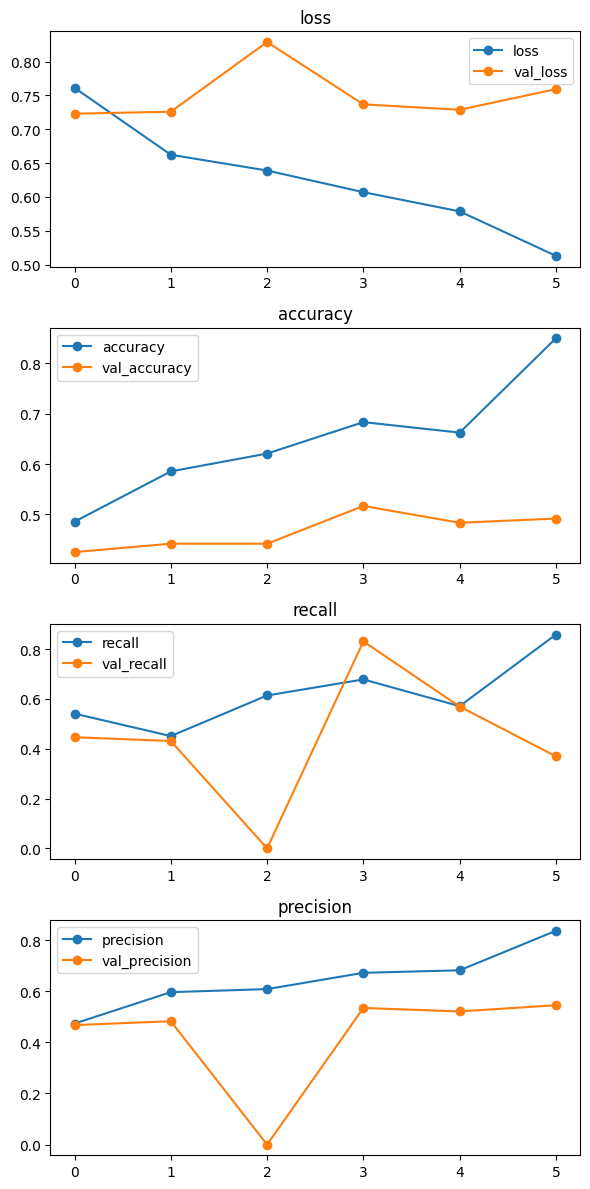

In [8]:
# plot learning
plot_history(history);

- The val_loss of the test data is not reducing as much as the loss of training data.
- The accuracy of the training data is significantly high than the test data, indicating that this model is overfitting on the training data.

## Evaluating the model

In [9]:
## make predictions
y_pred_test = bin_model.predict(X_test)
y_pred_test[:5]

32/32 [==============================] - 0s 2ms/step


array([[0.40426028],
       [0.3484417 ],
       [0.49806735],
       [0.3391497 ],
       [0.47422856]], dtype=float32)

In [10]:
# round the predictions
y_pred_test = np.round(y_pred_test)
y_pred_test[:5]

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)

              precision    recall  f1-score   support

           0       0.50      0.65      0.57       513
           1       0.47      0.32      0.38       487

    accuracy                           0.49      1000
   macro avg       0.49      0.49      0.47      1000
weighted avg       0.49      0.49      0.48      1000



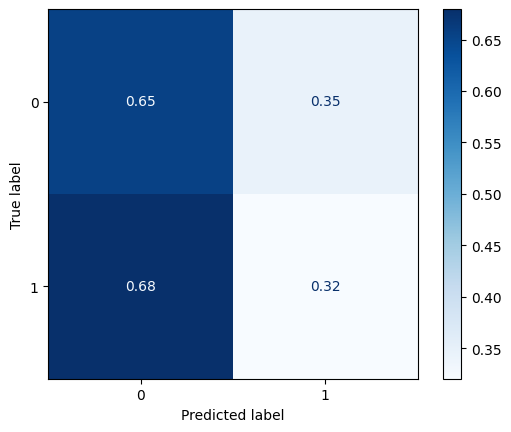

In [11]:
#Using a confusion matrix and a classification report
from sklearn.metrics import classification_report,ConfusionMatrixDisplay
print(classification_report(y_test, y_pred_test))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, cmap='Blues',
                                       normalize='true');



- The confusion matrix shows that the model's accuracy is low at 49%, and its performance in correctly predicting class 1 was very poor but performed slightly well in correctly predicting class 0.

## Tuning with the Keras tuner

In [12]:
pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.5 MB/s eta 0:00:00


In [13]:
from keras_tuner import HyperParameters as hp
import keras_tuner as kt

In [14]:
# Define the model building function for Keras Tuner
def build_model(hp):
  # Instantiate Model
    model = Sequential()

    # First hidden layer
    model.add(Dense(
        units=hp.Int('units_1', min_value=32, max_value=512, step=32),
        input_dim=input_shape,
        activation=hp.Choice('activation_1', ['relu', 'tanh', 'sigmoid'])
    ))

    # Second hidden layer
    model.add(Dense(
        units=hp.Int('units_2', min_value=32, max_value=512, step=32),
        activation=hp.Choice('activation_2', ['relu', 'tanh', 'sigmoid'])
    ))
    # Dropout layer
    model.add(Dropout(rate=hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))

    # Output layer
    model.add(Dense(1, activation='sigmoid'))

    # Compile model
    model.compile(
        optimizer=hp.Choice('optimizer', ['rmsprop', 'nadam', 'adam']),
        loss='bce',
        metrics=['accuracy',
                 tf.keras.metrics.Recall(name='recall'),
                 tf.keras.metrics.Precision(name='precision')]
    )

    return model

In [15]:
# Make a folder to store results of hyperparameter tuning
import os
Myfolder = 'KerasTuning/'
os.makedirs(Myfolder, exist_ok=True)

In [16]:
# Define tuner object
tuner = kt.Hyperband(build_model,
                     objective=kt.Objective('val_precision', direction='max'),
                     max_epochs=5,
                     directory=Myfolder,
                     overwrite = True,
                     seed = 42,
                     project_name='My_Hyperparameter_Tuning')


In [17]:
# Run the tuner
epochs = 100
tuner.search(X_train, y_train,  epochs=epochs,
             validation_data = (X_test, y_test), callbacks = [early_stop])

Trial 10 Complete [00h 00m 04s]
val_precision: 0.4869999885559082

Best val_precision So Far: 1.0
Total elapsed time: 00h 00m 46s


In [18]:
# Obtain best hyperparameter values
best_hps=tuner.get_best_hyperparameters()[0]
best_hps.values

{'units_1': 160,
 'activation_1': 'tanh',
 'units_2': 480,
 'activation_2': 'tanh',
 'dropout': 0.2,
 'optimizer': 'nadam',
 'tuner/epochs': 2,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 1,
 'tuner/round': 0}

In [19]:
# Retrieve the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model
results = best_model.evaluate(X_test, y_test)
print(f"Test Loss: {results[0]}")
print(f"Test Accuracy: {results[1]}")
print(f"Test Recall: {results[2]}")
print(f"Test Precision: {results[3]}")

32/32 [==============================] - 0s 3ms/step - loss: 0.7252 - accuracy: 0.5140 - recall: 0.0021 - precision: 1.0000
Test Loss: 0.7252150774002075
Test Accuracy: 0.5139999985694885
Test Recall: 0.002053388161584735
Test Precision: 1.0


#### Using the confusion matrix and classification report

In [20]:
## make predictions
y1_pred_test = best_model.predict(X_test)
# round the predictions
y1_pred_test = np.round(y1_pred_test)
y1_pred_test[:5]

32/32 [==============================] - 0s 2ms/step


array([[0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)

              precision    recall  f1-score   support

           0       0.51      1.00      0.68       513
           1       1.00      0.00      0.00       487

    accuracy                           0.51      1000
   macro avg       0.76      0.50      0.34      1000
weighted avg       0.75      0.51      0.35      1000



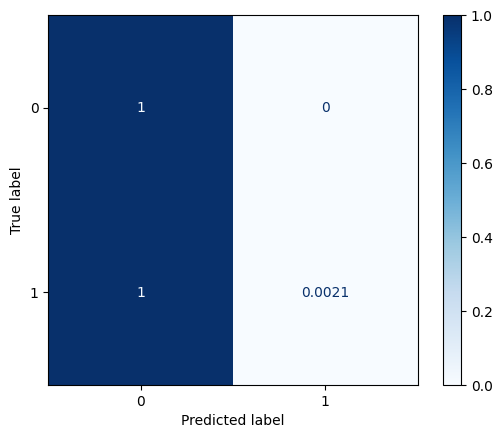

In [21]:
#Using a confusion matrix and a classification report to model the performance of the best model
from sklearn.metrics import classification_report,ConfusionMatrixDisplay
print(classification_report(y_test, y1_pred_test))

ConfusionMatrixDisplay.from_predictions(y_test, y1_pred_test, cmap='Blues',
                                       normalize='true');

- The best model(which involved tuning the hyperparameters like the activation function, the dropout rate and number of units used in the dense layer) slightly improved the accuracy in prediction of the classes to 51% from 49%. However, this is not a good enough model performance and the main reason for this could most probably be because we are using randomized data, and the data quality might not be sufficient for the model to learn patterns effectively.